In [4]:
import sys
sys.path.append("/opt/ml/level2_cv_semanticsegmentation-cv-08")
from utils.util import CLASS2IND, CLASSES
from PIL import Image, ImageDraw
import random
import cv2
import json
import glob
import numpy as np
import matplotlib.pyplot as plt

In [44]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

In [92]:
filenames = glob.glob("/opt/ml/data/train/DCM/**/*")
labelnames = glob.glob("/opt/ml/data/train/outputs_json/**/*.json")

In [93]:
img = filenames[np.random.randint(len(filenames))]
label_path = img.replace("DCM", "outputs_json").replace("png", "json")

In [94]:
image = cv2.imread(img) / 255.

In [95]:
label_shape = tuple(image.shape[:2]) + (len(CLASSES),)
label = np.zeros(label_shape, dtype=np.uint8)

# read label file
with open(label_path, "r") as f:
    annotations = json.load(f)
annotations = annotations["annotations"]

for ann in annotations:
    c = ann["label"]
    # CLASS2IND
    class_ind = CLASS2IND[c]
    points = np.array(ann["points"])

    # polygon to mask
    class_label = np.zeros(image.shape[:2], dtype=np.uint8)

    cv2.fillPoly(class_label, [points], 1)
    label[..., class_ind] = class_label

In [96]:
image = cv2.resize(image, (1024, 1024))
label = cv2.resize(label, (1024, 1024))

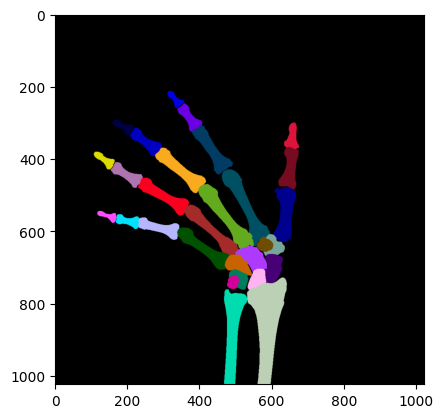

In [97]:
plt.imshow(label2rgb(label.transpose(2, 0, 1)))

In [88]:
def get_coord(polygon):
    polygon = polygon
    for i in range(len(polygon)):
        polygon[i] = tuple(polygon[i])
    polygon_np = np.array(polygon)
    max = np.max(polygon_np, axis=0)
    min = np.min(polygon_np, axis=0)
    return max, min

In [98]:
randoms = random.choices([i for i in range(800)], k=3)
for i in randoms:
    target_image = cv2.imread(filenames[i]) / 255.
    target_label_path = labelnames[i]

    with open(target_label_path, "r") as f:
        target_annotations = json.load(f)
    target_annotations = target_annotations["annotations"]

    for ann in target_annotations:
        target_c = ann["label"]
        target_c = CLASS2IND[target_c]
        if target_c == 19 or target_c == 20 or target_c == 25 or target_c == 26:
            max, min = get_coord(ann['points'])
            scale = (image.shape[0] / 2048)
            max = [int(i * scale) for i in max]
            min = [int(i * scale) for i in min]
            range_max = int(1800. * scale)
            range_min = int(100. * scale)
            x = random.randint(range_min, range_max)
            y = random.randint(range_min, range_max)
            alpha = int(random.randint(25,50) * scale)
            # 0. check whether generated (x,y) coordinate is in the background 
            bone_area_x = [i for i in range(int(400 * scale), int(1600 * scale))]
            while x in bone_area_x:
                x = random.randint(100 * scale,1800 * scale)
            x -= alpha            
            # 1. create mask for new image
            img = Image.new('L', target_image.shape[:2], 0)
            ImageDraw.Draw(img).polygon(ann['points'], outline=0, fill=1)
            mask = np.array(img)
            # 2. paste maskout poly to source image
            new_image = cv2.bitwise_or(target_image, target_image, mask=mask)
            new_image = cv2.resize(new_image, 
                                image.shape[:2], 
                                interpolation=cv2.INTER_AREA)
            mask = cv2.resize(mask, image.shape[:2], interpolation=cv2.INTER_AREA)
            if image.shape[-1] == 3:
                image[y:y+max[1]-min[1], x:x+max[0]-min[0], ...] = new_image[min[1]:max[1], min[0]:max[0], ...]
            else:
                image[y:y+max[1]-min[1], x:x+max[0]-min[0], 0] = new_image[min[1]:max[1], min[0]:max[0], 0]                        

            # 3. update label
            ori_label = label[..., target_c]
            ori_label[y:y+max[1]-min[1], x:x+max[0]-min[0]] = mask[min[1]:max[1], min[0]:max[0]]
            label[..., target_c] = ori_label
                       

In [99]:
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

In [83]:
label.shape

(1024, 1024, 29)

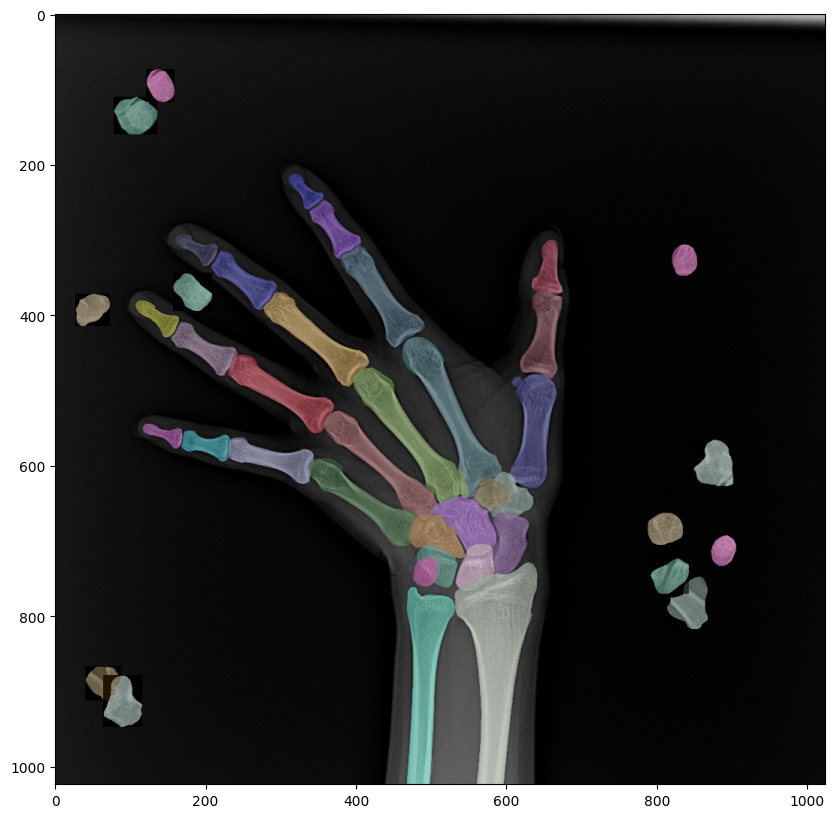

In [100]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(label2rgb(label.transpose(2, 0, 1)), alpha=0.3)

In [21]:
scale

1.0